In [2]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import os
import multiprocessing as mp

# Read In Files

In [3]:
reads = []
with open("data/reads.fq") as f:
    for i, read in enumerate(f):
        if i % 4 == 1:  
            reads.append(read.strip())

In [4]:
#look at 10 reads
reads[:10]

['TCCTTACTGGTTTTGCAGGTAACTTATAGAGTATTTCCACTTCCCTTCTCCTATCCCTTGAAAAATTGTCATTTATTTCTCTTATCCATATGGCATAATC',
 'GGTTTTTCAGGTAACTTATAGAGTATTTCCACTTCCCTTCTCCTATCCCTGGAAAAATTGTCATTTATTTCTCTTATCCATATGGCATAATCAAAGAATA',
 'AGGTAACTTATAGAGTACTTCCACTTCCCTTCTCCTATCCCTTGAAAAATTGTCATTGATTTCTCTTATCCATATGGCATAATCAAAGAATAAATTGGTG',
 'CACTTCCCTTCTACTATCCCTTGAAAAATTGTCATTTATTTCTCTTATCCATATGGCATAATCAAAGAATAAATTGGTGATATTTGTTCAAAAATCCATG',
 'CCTTCTCCTATCCCTTGAAAAATTGTCATTTATTTCCCTTATCCATATGGCATAATCAAAGAATAAATTGGTGATATTTGTTCAAAAATCCATGCCTTTT',
 'ATCCCTTGAAAAATTGTCATTTATTTCTCTTATCCATATGGCATAATCAAAGAATAAATTGGTGATATTTGTTCAAAAATCCGTGCCTATTAGATTCATT',
 'TCTTATCCATATGGCATAATCAAAGAATAAATTGGTGATATTTGTTCAAAAATCCATGCCTATTAGATTCATTTAGAATATAAAAAAATTTTATTTTATT',
 'TATCCATATGGCATAATCAAAGAATCAATTGTTGATATTTGTTCAAAAATCCATGCCTATTAGATTCATTTAGAATATAAAAAAATTTTATTTTATTTTC',
 'TCAAAGAATAAATTGGTGATATTTGTTCAAAAATCCATGCCTATTAGATTCATTTAGATTATAAAAAAATTTTATTTTATTTTCACTTATTTCTTCTCCA',
 'TGAATAAATTGGTGATATTTGTTCAAAAATCCATGCCTACTAGATTCATTTAG

In [5]:
bin_names = []
bins_file_df = pd.read_csv("data/reference_chr21_20000000_20050000.fa")
for i,row in bins_file_df.iterrows():
    bin_names.append("bin"+str(row['start'])+"_"+str(row['end']))
bins = list(bins_file_df['sequence'])
bin_starts = bins_file_df['start']

In [6]:
#look at 10 bins
bins[:10]

['CCCTTCTCCTATCCCTTGAAAAATTGTCATTTATTTCTCTTATCCATATGGCATAATCAAAGAATAAATTGGTGATATTTGTTCAAAAATCCATGCCTAT',
 'TAGATTCATTTAGAATATAAAAAAATTTTATTTTATTTTCACTTATTTCTTCTCCACTGATTTTTCTATTTTTATGTAGAGATGAGTTTCTGACATATAT',
 'TTCTTCTTCCTGAAGAAAATATTTTAACATTTCCTGCATGGGTGGTCTCTGGTCATAAATTCCCTTAGTTTTTGTTTGAGCAAGTATTTATCTGTTGATG',
 'ACTTTTCAAGGATAGTTTTGTGGGATACAGAATTCTAGATCAGCGTTTTTTTTTTTTTTCCCTTTCTACTCTTGATATAGTTCATCCCACACTCTTCTTG',
 'CTGACAGGACTTCTGCCAAGGACAACTTTCCTGTAATGTTTATCTTTCCTTATTCCTCCATAGGTAAGGTTGTTTTTTTGTTTTTGTTTTTTTCTCAGAA',
 'TTTCCTTTTTTTTTTCTTTTTCTTTCTGCAGTTTGACTTTGCCATGCATAGGTGTCATTTTTTGTTATTTATCCTATGTCCTGTTTTTACATTTTTTTTA',
 'ATTATAAAAAGGGAGGGTGCTTATTGGCTTCCTGGATCTATGGTTTCTTAATTGTCACCAATTTTATAATGTTCTCCACCACTCTTGCTTCAAATATTTT',
 'TTCTTTTCTTTTTCTCCTCTTGGCATTCCAATTGTGCATATGTTACAACTTTTGAATTTGCCCAGAAGTTCTTGGATATTACGTTTTTCTCTTTTTTTCT',
 'ATAAATTTCTGCTTGAAAAGTTTCTACTGATTTATCTTCTGAATCACCAGTTCTTTCCTCAGTCAGTTTATTGATGTGTACATCCAAACCATTCTTAATT',
 'TTCGTTAGTGTTTTTTAATTTTACGAATTTCTATTGATACTTTCATAGAGTTT

# Find Distinct Kmers in every Read

In [7]:
distinct_kmers = set()
k = 15
for r in reads + bins:
    for i in range(len(r) - k+1):
        distinct_kmers.add(r[i:i+k])
distinct_kmers = np.array(list(distinct_kmers))
len(distinct_kmers) #number of distinct k-mers

72530

In [8]:
m = list(distinct_kmers)
m.sort()
m

['AAAAAAAAAAAAAAA',
 'AAAAAAAAAAAAAAC',
 'AAAAAAAAAAAAAAG',
 'AAAAAAAAAAAAACT',
 'AAAAAAAAAAAAAGA',
 'AAAAAAAAAAAAAGT',
 'AAAAAAAAAAAACTT',
 'AAAAAAAAAAAAGAA',
 'AAAAAAAAAAAAGTG',
 'AAAAAAAAAAACTTC',
 'AAAAAAAAAAAGAAA',
 'AAAAAAAAAAAGTGC',
 'AAAAAAAAAAAGTGG',
 'AAAAAAAAAACTTCT',
 'AAAAAAAAAAGAAAG',
 'AAAAAAAAAAGAAAT',
 'AAAAAAAAAAGTGCT',
 'AAAAAAAAAAGTGGT',
 'AAAAAAAAAATTCTA',
 'AAAAAAAAACTTCTT',
 'AAAAAAAAAGAAAAA',
 'AAAAAAAAAGAAAGG',
 'AAAAAAAAAGAAATG',
 'AAAAAAAAAGCAGGG',
 'AAAAAAAAAGGGAGA',
 'AAAAAAAAAGTGCTT',
 'AAAAAAAAAGTGGTT',
 'AAAAAAAAATAGATG',
 'AAAAAAAAATTCTAG',
 'AAAAAAAAATTGATG',
 'AAAAAAAACATCTTA',
 'AAAAAAAACTTCTTA',
 'AAAAAAAAGAAAAAA',
 'AAAAAAAAGAAAATG',
 'AAAAAAAAGAAAGGC',
 'AAAAAAAAGAAATGT',
 'AAAAAAAAGACAAAC',
 'AAAAAAAAGCAGGGG',
 'AAAAAAAAGGGAGAG',
 'AAAAAAAAGTCAAAC',
 'AAAAAAAAGTGCTTT',
 'AAAAAAAAGTGGTTT',
 'AAAAAAAATAGATGA',
 'AAAAAAAATCACAAA',
 'AAAAAAAATTCTAGA',
 'AAAAAAAATTGATGA',
 'AAAAAAAATTTGAGT',
 'AAAAAAAATTTTATG',
 'AAAAAAACAGAAAAA',
 'AAAAAAACATCTTAA',


In [9]:
def kmer_set(read, k):
    kset = set()
    for i in range(len(read)-k):
        kset.add(read[i:i+k])
    return(kset)

def kmer_vec(read, distinct_kmers, k):
    kset = kmer_set(read,k)
    kvec = np.isin(distinct_kmers,list(kset))
    return(kvec)

def process_kmer_vec(args):
    return(kmer_vec(args[0],args[1],args[2]))

In [10]:
len(os.sched_getaffinity(0)) #number of accessible cpus

24

In [11]:
start = time.time()
pool = mp.Pool(20)
read_kvecs = pool.starmap(kmer_vec, [(read, distinct_kmers, k) for read in reads])
bin_kvecs = pool.starmap(kmer_vec, [(bin_, distinct_kmers, k) for bin_ in bins])
pool.close()
pool.join()
time_tot = time.time() - start
print(time_tot)

10.042780637741089


In [12]:
read_kvecs

[array([False, False, False, ..., False, False, False]),
 array([False, False, False, ..., False, False, False]),
 array([False, False, False, ..., False, False, False]),
 array([False, False, False, ..., False, False, False]),
 array([False, False, False, ..., False, False, False]),
 array([False, False, False, ..., False, False, False]),
 array([False, False, False, ..., False, False, False]),
 array([False, False, False, ..., False, False, False]),
 array([False, False, False, ..., False, False, False]),
 array([False, False, False, ..., False, False, False]),
 array([False, False, False, ..., False, False, False]),
 array([False, False, False, ..., False, False, False]),
 array([False, False, False, ..., False, False, False]),
 array([False, False, False, ..., False, False, False]),
 array([False, False, False, ..., False, False, False]),
 array([False, False, False, ..., False, False, False]),
 array([False, False, False, ..., False, False, False]),
 array([False, False, False, ..

In [13]:
reads_names = [f"read{i}" for i in range(len(read_kvecs))] 
reads_data = {col:read_kvecs[i] for i,col in enumerate(reads_names)}
reads_df = pd.DataFrame(reads_data,index = distinct_kmers)
 
bins_data = {col:bin_kvecs[i] for i,col in enumerate(bin_names)}
bins_df = pd.DataFrame(bins_data,index = distinct_kmers)

In [14]:
reads_df[:10]

,read0,read1,read2,read3,read4,read5,read6,read7,read8,read9,...,read1990,read1991,read1992,read1993,read1994,read1995,read1996,read1997,read1998,read1999
TTATAAATGTTTCAC,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
AATATTCATATTAGG,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
TAAACATCATGGCTT,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
AAGTGAGACATCTAG,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
CACATGATCTTATAC,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
CTCTCTAAGATTACA,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
AGCCTGTGGTTTCAT,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
ATTTTATGTCTCTGG,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
GTATCGGCTATACGT,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
CCTTCCCTCACAGAT,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [15]:
bins_df[:10]

,bin20000000_20000100,bin20000100_20000200,bin20000200_20000300,bin20000300_20000400,bin20000400_20000500,bin20000500_20000600,bin20000600_20000700,bin20000700_20000800,bin20000800_20000900,bin20000900_20001000,...,bin20049000_20049100,bin20049100_20049200,bin20049200_20049300,bin20049300_20049400,bin20049400_20049500,bin20049500_20049600,bin20049600_20049700,bin20049700_20049800,bin20049800_20049900,bin20049900_20050000
TTATAAATGTTTCAC,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
AATATTCATATTAGG,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
TAAACATCATGGCTT,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
AAGTGAGACATCTAG,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
CACATGATCTTATAC,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
CTCTCTAAGATTACA,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
AGCCTGTGGTTTCAT,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
ATTTTATGTCTCTGG,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
GTATCGGCTATACGT,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
CCTTCCCTCACAGAT,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


# Calculate Minhash Signatures

In [16]:
rng = np.random.default_rng(seed = 5460)
hashes = []
signature_length = 1000
for i in range(signature_length):
    hashes.append(rng.permutation(len(distinct_kmers)))

In [17]:
def get_minhash(kvec, hash_):
    minhash = np.min(hash_[kvec])
    return(minhash)

def get_signature(kvec, hashes):
    signature = []
    for hash_ in hashes:
        signature.append(get_minhash(kvec,hash_))
    return(np.array(signature))

In [18]:
bin_kvecs

[array([False, False, False, ..., False, False, False]),
 array([False, False, False, ..., False, False, False]),
 array([False, False, False, ..., False, False, False]),
 array([False, False, False, ..., False, False, False]),
 array([False, False, False, ..., False, False, False]),
 array([False, False, False, ..., False, False, False]),
 array([False, False, False, ..., False, False, False]),
 array([False, False, False, ..., False, False, False]),
 array([False, False, False, ..., False, False, False]),
 array([False, False, False, ..., False, False, False]),
 array([False, False, False, ..., False, False, False]),
 array([False, False, False, ..., False, False, False]),
 array([False, False, False, ..., False, False, False]),
 array([False, False, False, ..., False, False, False]),
 array([False, False, False, ..., False, False, False]),
 array([False, False, False, ..., False, False, False]),
 array([False, False, False, ..., False, False, False]),
 array([False, False, False, ..

In [19]:
start = time.time()
pool = mp.Pool(20)
read_signatures = pool.starmap(get_signature,[(kvec,hashes) for kvec in read_kvecs])
bin_signatures = pool.starmap(get_signature,[(kvec,hashes) for kvec in bin_kvecs])
pool.close()
pool.join()
print(time.time() - start)                        

320.3252201080322


# Find Most Similar Bin by Comparing Signatures

In [20]:
def get_similarity(read_sig, bin_sigs):
    sims = np.mean(read_sig == bin_signatures,axis=1)
    return(sims)

In [21]:
start = time.time()
pool = mp.Pool(20)
read_similarities = pool.starmap(get_similarity,[(r,bin_signatures) for r in read_signatures])
pool.close()
pool.join()
print(time.time() - start) 

2.5272486209869385


In [22]:
#put results of minhash in a dataframe
most_similar_bin = np.array([bin_names[np.argmax(s)] for s in read_similarities])
most_similar_bin_start = np.array([bin_starts[np.argmax(s)] for s in read_similarities])
highest_similarity = np.array([np.max(s) for s in read_similarities])
res = pd.DataFrame({"readname":reads_names,"bin":most_similar_bin,
                    "bin_start":most_similar_bin_start,"sim":highest_similarity})

In [23]:
res[1:2000:500]

,readname,bin,bin_start,sim
1,read1,bin20000000_20000100,20000000,0.280
501,read501,bin20011800_20011900,20011800,0.675
1001,read1001,bin20022700_20022800,20022700,0.210
1501,read1501,bin20033100_20033200,20033100,0.515


# Compare the Result to the Reference

In [24]:
ref = pd.read_csv('data/read_position_benchmark.csv', index_col = 0)
res['ref_bin_start'] = ref['reference_start']

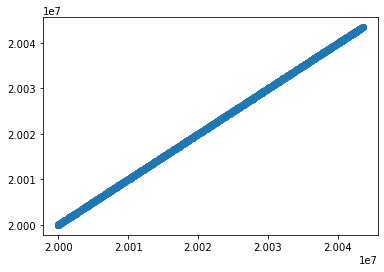

In [25]:
plt.scatter(res['bin_start'],res['ref_bin_start'])

In [26]:
errs = res['bin_start'] - res['ref_bin_start']
np.max(errs)

61

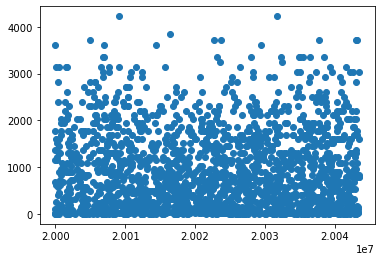

In [27]:
plt.scatter(res['ref_bin_start'], np.square(errs))

In [28]:
#calculate mean square error and root mean squared error, accuracy, pearson correlation
mse = np.mean(np.square(errs))
rmse = np.sqrt(mse)
acc = 1 - (np.sum(abs(errs) > 50) / 2000)
pearson = np.corrcoef(res['bin_start'],res['ref_bin_start'])[0,1]

In [29]:
(np.sum(abs(errs) > 100))

0

In [30]:
mse

893.2645

In [31]:
rmse

29.88753084481888

In [32]:
acc

0.9535

In [33]:
pearson

0.9999971242615758

In [34]:
np.sqrt(np.mean(np.square(np.linspace(0,50,51)))) #best theoretical rmse

29.011491975882016

In [35]:
#calculate pearson coefficient
np.corrcoef(res['bin_start'],res['ref_bin_start'])[0,1]

0.9999971242615758

In [36]:
#theroetical best mse
np.mean(np.square(np.linspace(0,50,51)))

841.6666666666666

In [37]:
rmse

29.88753084481888